# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [1]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print("Dataset has {} rows, {} columns".format(*data.shape))
print(data.head())  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer: Since PCA is going to look to create features that maximize variance, we should see it identify common patterns for different purchaser profiles. ICA on the other hand is looking for statistically unrelated sources and so will likely identify something like the underlying store type (corner store vs. full grocery vs. deli).

### PCA

In [2]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# Scale the data using Normalization
scaled = normalize(data)

# Build and run the PCA analysis with the number of components set to the original number 
# of features as requested. 
pca = PCA(n_components=data.shape[1])
pca.fit_transform(scaled)

# Print the components and the amount of variance in the data contained in each dimension
dispDF = pd.DataFrame(pca.components_)
dispDF.columns = data.columns
dispDF = dispDF.reset_index()
dispDF['Expl_Variance'] = pca.explained_variance_ratio_
dispDF['Cum_Variance'] = dispDF['Expl_Variance'].cumsum()

dispDF = dispDF.T
dispDF.columns = ["P.C. {}".format(r) for r in range(1,7,1)]
dispDF.drop(['index'], axis=0, inplace=True)
dispDF

,P.C. 1,P.C. 2,P.C. 3,P.C. 4,P.C. 5,P.C. 6
Fresh,-0.720606,0.325226,-0.066263,0.253652,-0.545133,-0.095159
Milk,0.344109,-0.057227,-0.853474,0.043070,-0.330984,-0.196193
Grocery,0.537571,0.220449,0.405897,0.589184,-0.314658,-0.226980
Frozen,-0.106800,-0.898543,0.183398,0.077656,-0.365427,-0.089507
Detergents_Paper,0.247658,0.167915,0.206943,-0.611852,-0.600605,0.364081
Delicatessen,0.024347,-0.082343,-0.161182,0.454174,-0.002605,0.871990
Expl_Variance,0.681885,0.146152,0.096222,0.033272,0.021943,0.020526
Cum_Variance,0.681885,0.828037,0.924259,0.957531,0.979474,1.000000


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: 
By the third principal component, we have almost 93% of the variance explained and by the fourth, 96%. I'd probably stop at the fourth to reduce the chances of overfitting in an eventual model and to keep it simpler unless there were other factors needed.

**3)** What do the dimensions seem to represent? How can you use this information?


Answer: The dimensions appear to show relationships between what is frequently purchased together. This information could be used in clustering order types potentially.

The first component has a correlation between Groceries, Milk amd Detergents & Paper with a strong negative relationship with Fresh Produce. This could be showing the overall demand for less-perishable foods. 

The second correlates with an increase in Detergents and Paper and then with Frozen products and is negtively related with the other categories to various levels. This might represent bulk purchases for end-customers since frozen items and sundries tend to be sold in bulk.

The third component is strongly related to the Deli products and then the Frozen and Milk and strongly negatively with Fresh produce purchases. This could point to orders from convinience stores and gas stations where the majority of the product is non-perishable or delicatessen in nature.

### ICA

In [3]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
ica = FastICA(n_components=data.shape[1])
ica.fit_transform(scaled)

# Print the independent components
icaDf = pd.DataFrame(ica.components_)
icaDf.columns = data.columns
icaDf = icaDf.T
icaDf.columns = dispDF.columns = ["I.C. {}".format(r) for r in range(1,7,1)]
icaDf

,I.C. 1,I.C. 2,I.C. 3,I.C. 4,I.C. 5,I.C. 6
Fresh,-0.045896,0.061116,0.086054,0.197863,-0.100477,0.260862
Milk,-0.052372,0.066254,0.051739,-0.110402,-0.134412,0.264266
Grocery,-0.217305,0.065475,0.029898,0.236447,-0.194120,0.055404
Frozen,-0.001521,0.052420,-0.204524,0.107799,-0.100932,0.165793
Detergents_Paper,0.449357,-0.000173,0.026754,0.134148,-0.095248,0.176702
Delicatessen,0.065380,-0.552304,0.031832,0.123463,-0.009267,0.015594


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: The independant components could represent the type of store represented by each order group:

1. IC 1 is focused on detergents and paper products and to a lesser extent, Deli and Frozen. This could represent corner stores and other types of businesses that primarily sell convinience products.

2. IC 2 is focused on the first four categories, not related to sundries and very negatively focused on delicatessen. This would likely be aimed at grocers who do not have in store hot deli or ready heated products.

3. IC 3 is focused on Fresh and Dairy, with a weaker association to Groceries, Sundries and Deli. This could represent smaller urban grociers who hvae an emphasis on their produce.

4. IC 4 is focused Grocery and Fresh with some emphasis on Frozen, Sundries and Deli with a negative relationship to Dairy products. 

5. IC 5 is universally negative.

6. IC 6 is centered on Fresh and Milk with moderate relationships in Frozen and Sundries and weaker relationships with Grocery and Deli.

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: By using Gaussian mixtures, we can easily describe simple clusters in the dataset. This can help to illustrate clusters that can be found accross multiple dimensions/features.

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [4]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [5]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation

pcaR = PCA(n_components=2, whiten=True)
reduced_data = pcaR.fit_transform(scaled)
print reduced_data[:10]  # print upto 10 elements

[[ 0.0747855   0.85626054]
 [ 0.77133585  0.22136883]
 [ 0.67096448 -0.26364005]
 [-0.84300783 -0.76783623]
 [-0.70000196  0.36529224]
 [ 0.08205991  0.56880451]
 [-0.26404871  1.15456387]
 [ 0.5268229   0.49428428]
 [ 0.36407001  0.89197463]
 [ 1.24993937  0.51819534]]


In [6]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'
mod = GMM(n_components=2)
mod.fit(reduced_data)
clusters = mod
print(clusters)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)


In [7]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [8]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroids = mod.means_

print centroids

[[-0.53239852 -0.10721975]
 [ 1.28809176  0.25940882]]


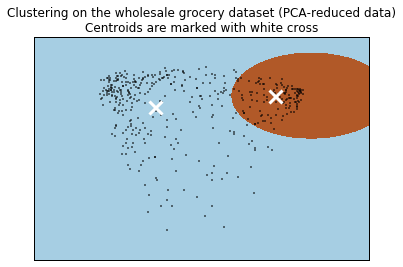

In [9]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: The main difference between the clusters is in the first principal component so would represent customers purchasing larger amounts of less-perishable foods. The second component seems to focus on items frequently sold in bulk. Our first cluster would be stores purchasing more non-perishable and bulk items than the other.

### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: I felt that PCA provided a more useful resulting feature set in the context of trying to identify buying patterns. Depending on the end goal of the segmentation project, ICA or other methods could have been more useful.

**9)** How would you use that technique to help the company design new experiments?

Answer: I'd try to engineer the tests to ensure both samples draw evenly from each cluster of customers to ensure they are appropriatly balanced.

**10)** How would you use that data to help you predict future customer needs?

Answer: By understanding the buying motives and needs of our customers, we can tailor the selling and relationship management processes to the most appropriate model for that type of customer. This makes for a better customer relationship since we can work to anticipate their needs and possibly stock new products that would appeal to them or run promotions that would compliment their businesses. 